In [2]:
import numpy as np
from matplotlib import pyplot as plt
import random
import math

DEBUGGING = False
SPLIT_SIZE = 5

## 2 Trees and Random Forests
(a)

The following function computes Gini impurity using the following formula:
$1 - \sum_{classes}p^2$

In [2]:
def impurity_calculator(labels):
    number_of_measurements = len(labels)
    class_counts = {}

    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    gini_impurity = 1.0
    
    for label in class_counts:
        probability = class_counts[label] / number_of_measurements
        gini_impurity -= probability ** 2
        
    return gini_impurity

In the following I computed the entropy as: $\sum_{classes} p \cdot log_2(p)$

In [3]:
def entropy_calculator(labels):
    number_of_measurements = len(labels)
    class_counts = {}

    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    entropy = 0.0
    for label in class_counts:
        probability = class_counts[label] / number_of_measurements
        entropy -= probability * math.log2(probability)
        
    return entropy

In the following block we are going to compute the misclassification rate and to do that we are going to suppose that the first set contains points that should be classified as zeros while the second one contains points that should be classified as ones.
<br>
Thus the misclassification rate is the rate over all of the predictions of choosing to put a 1 inside the zero set and vice versa.

In [4]:
def misclassification_rate_calculator(labels, prediction):
    number_of_measurements = len(labels)
    class_counts = {}

    for label in labels:
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    for label in class_counts:
        if label != prediction:
            misclassification_rate = class_counts[label] / number_of_measurements
    return misclassification_rate

In the following block we do the actual computation for the three indices and we plot the subsequent values.
<br>
To avoid having too many points inside the plot (and to reduce noise) we decided to define a variable that would state how big the skips inside the dataset would be (basically the variable choses how big the splits are)

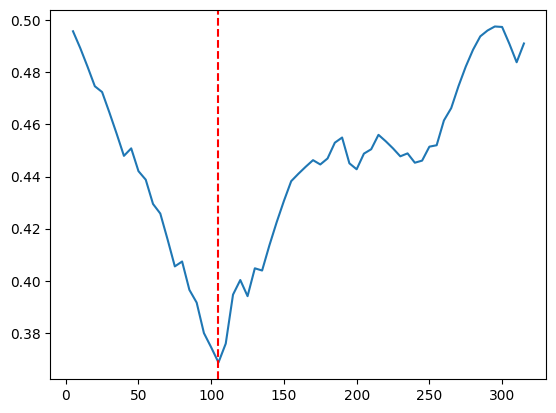

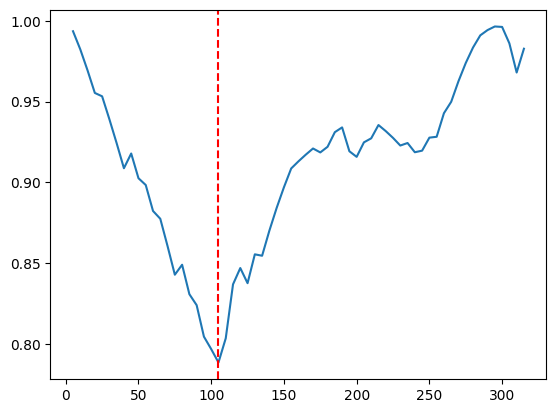

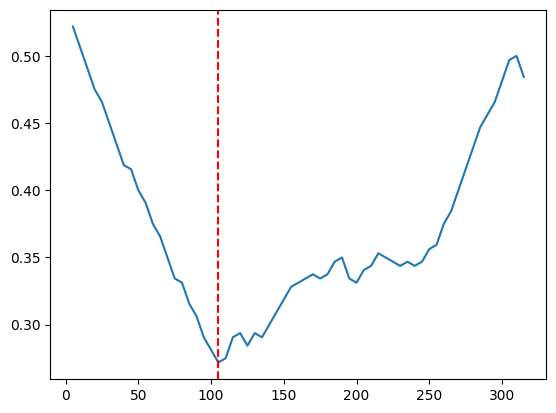

In [5]:
# Very inefficient auxiliary function that computes the position of the minimum in a list
def argmin(list):
    min = list[0]
    position = 0
    i = 0
    for element in list:
        i += 1
        if element < min:
            min = element
            position = i
    return position * SPLIT_SIZE

# load the data
pts = np.load('Data/data1d.npy')
labels = np.load('Data/labels1d.npy')

# Sort the points to easily split them
sorted_indices = np.argsort(pts)
sorted_data = pts[sorted_indices]
sorted_labels = labels[sorted_indices]
total_size = len(sorted_data)

impurities = []
entropies = []
errors = []

# Main cycle that computes all of the interesting quantities
for i in range(SPLIT_SIZE, total_size, SPLIT_SIZE):
    
    test_values = np.split(sorted_data, [i])
    test_labels = np.split(sorted_labels, [i])        

    # In the following we compute the impurity for both the splits and compute the "cumulated" impurity as the weighted 
    # summation of the contributions
    impurity_0 = impurity_calculator(test_labels[0])
    impurity_1 = impurity_calculator(test_labels[1])
    impurity = (i / total_size) * impurity_0 + ((total_size - i) / total_size) * impurity_1
    impurities.append(impurity)

    # In the following we compute the entropy for both the splits and compute the "cumulated" entropy as the weighted 
    # summation of the contributions
    entropy_0 = entropy_calculator(test_labels[0])
    entropy_1 = entropy_calculator(test_labels[1])
    entropy = (i / total_size) * entropy_0 + ((total_size - i) / total_size) * entropy_1
    entropies.append(entropy)

    # In the following we compute the misclassification rate for both the splits and compute the "cumulated" 
    # misclassification rate as the weighted summation of the contributions
    miss_rate_0 = misclassification_rate_calculator(test_labels[0], 0)
    miss_rate_1 = misclassification_rate_calculator(test_labels[1], 1)
    miss_rate = (i / total_size) * miss_rate_0 + ((total_size - i) / total_size) * miss_rate_1
    errors.append(miss_rate)

if DEBUGGING:
    print(number_of_test_subjects)
    print(len(test_values[0]))
    print("Gini impurity -- ", impurities[len(impurities) - 1])
    print("entropy -- ", entropies[len(entropies) - 1])
    print("misclassification -- ", errors[len(errors) - 1])
    print(impurities)

# Compute the minimum points
min_impurity = argmin(impurities)
min_entropy = argmin(entropies)
min_misclassification_error = argmin(errors)

if DEBUGGING:
    print(str(min_impurity) + "\t" + str(min_entropy) + "\t" + str(min_misclassification_error))

# Plot the points
plt.plot(np.arange(SPLIT_SIZE, total_size, SPLIT_SIZE), impurities)
plt.axvline(x=min_impurity, color='red', linestyle='--', label='minimum')
plt.show()

plt.plot(np.arange(SPLIT_SIZE, total_size, SPLIT_SIZE), entropies)
plt.axvline(x=min_entropy, color='red', linestyle='--', label='minimum')
plt.show()

plt.plot(np.arange(SPLIT_SIZE, total_size, SPLIT_SIZE), errors)
plt.axvline(x=min_misclassification_error, color='red', linestyle='--', label='minimum')
plt.show()


In this block we defined the classification task as a separate function that requires a criterion as an argument and basically takes care of the rest doing the training and then computing the accuracies that are later passed to the caller through a 

In [14]:
def classification_task(criterion):
    number_of_classifiers = [5, 10, 20, 100]
    leaf_purity = [2, 5, 10, None]
    accuracies = []
    
    for number_of_elements in number_of_classifiers:
        for purity in leaf_purity:
            classifier = RandomForestClassifier(n_estimators=number_of_elements, criterion="gini", random_state=3129, max_depth=purity)
            classifier.fit(xtrain, ytrain)
            predictions = classifier.predict(xvalidation)
            accuracy = accuracy_score(yvalidation, predictions)
            classifier_info = {
                "classifier": classifier,
                "accuracy": accuracy
            }
            accuracies.append(classifier_info)
    return accuracies

In the following block data is setup so that it can be passed through the various types of forests

In [15]:
# load the dijet data
features = np.load('Data/dijet_features_normalized.npy')
labels = np.load('Data/dijet_labels.npy')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Training setup
indices = list(range(len(labels)))
random.shuffle(indices)
shuffled_labels = labels[indices]
for i in range(len(features)):
    features[i] = features[i][indices]
xtest = features.T[:200]
xvalidation = features.T[200:400]
xtrain = features.T[400:]
ytest, yvalidation, ytrain = np.split(shuffled_labels, [200, 400])

# The output is rendered as a list of dictionary instances containing the classifier and its accuracy in a validation setting
accuracies = [] + classification_task("gini") + classification_task("entropy")

if DEBUGGING:
    print(accuracies)
    
print("Done")


Done


In the last couple of boxes we computed the best classifier overall and we computed the accuracy over the set of test data

In [23]:
def best_classifier(list_of_classifier_descriptors):
    max = list_of_classifier_descriptors[0]
    for classifier in list_of_classifier_descriptors:
        if float(classifier.get("accuracy")) > float(max.get("accuracy")):
            max = classifier
    return max

In [24]:
best_classifier = best_classifier(accuracies)
print("The best classifier is \n" + str(best_classifier))
predictions = best_classifier.get("classifier").predict(xtest)
test_accuracy = accuracy_score(ytest, predictions)
print("test accuracy <--> " + str(test_accuracy))
if(test_accuracy < best_classifier.get("accuracy")):
    print("The classifier performed worse in the test environment")
else:
    print("The classifier performed better in the test environment")

The best classifier is 
{'classifier': RandomForestClassifier(max_depth=10, n_estimators=5, random_state=3129), 'accuracy': 0.775}
test accuracy <--> 0.715
The classifier performed worse in the test environment


# 3) Fits

(b) Minimizing the one parameter negative log-likelihood and extract the estimator for R

The likelihood estimator for R is 9.02
The valure of the negative log-likelihood at its minimum is 11917318940.03


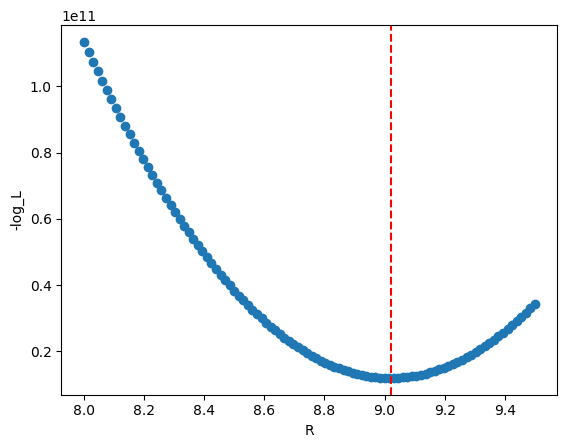

In [3]:
from scipy.optimize import minimize

#load data
data_Vm, data_p = np.load("Data/gas.npy")

#function computing the ideal gas law given volume and a parameter
T=293
def idealgas(x,v):
    return T*x/v 

#function computing the negative log-likelihood wich recalls the ideal gas law
def n_log_L(x,p,v):
    return np.sum((p - idealgas(x,v))**2)


#minimize the negative log-likelihood and printing the results
res=minimize(n_log_L,8,(data_p,data_Vm))
print(f"The likelihood estimator for R is {res.x[0]:.2f}")
minL=n_log_L(res.x[0],data_p,data_Vm)
print(f"The valure of the negative log-likelihood at its minimum is {minL:.2f}")


#filling an array with values of the negative log-likelihood
X0=np.linspace(8,9.5,len(data_p))
Y0=[]
for i in X0:
    Y0.append(n_log_L(i,data_p,data_Vm))

    
#plotting the negative log-likelihood
plt.scatter(X0,Y0)
plt.xlabel("R")
plt.ylabel("-log_L")
plt.axvline(x=res.x[0], color='red', linestyle='--', label='minimum')
plt.show()

(c) Minimizing the negative log-likelihood and extract the estimators for a and b

The likelihood estimators for a and b are 4.2304, 0.0012
The valure of the negative log-likelihood at its minimum is 2732646305.16


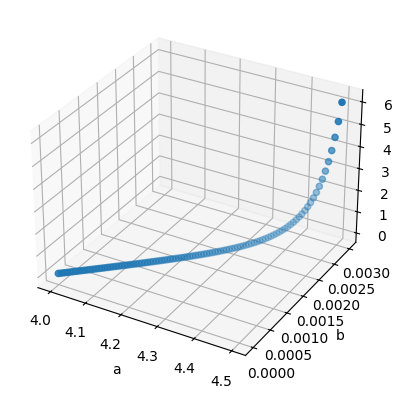

The ratio between the minimun value of the negative log-likelihood obtained using the idea gas law and the one obtained using the real gas law is 4.3611


In [6]:
#defining R as the result from the previous minimization
R=res.x[0]

#function computing the real gas law given volume and an array of two parameters
def realgas(x,v):
    return  R*T/(v-x[1]) - x[0]/v**2

#function computing the negative log-likelihood
def n_log_l(x,p,v):
    return np.sum((p - realgas(x,v))**2)

#minimizing the negative log-likelihood and printing the results
Res=minimize(n_log_l,(0,0),(data_p,data_Vm))
print(f"The likelihood estimators for a and b are {Res.x[0]:.4f}, {Res.x[1]:.4f}")
minl=n_log_l([Res.x[0],Res.x[1]],data_p,data_Vm)
print(f"The valure of the negative log-likelihood at its minimum is {minl:.2f}")


#filling an array X with the couples of possible values of a,b
a=np.linspace(4,4.5,len(data_p))
b=np.linspace(0,0.003,len(data_p))
X=np.ndarray((len(data_p),2))

for i in range(0,len(data_p)):
    X[i][0]=a[i]
    X[i][1]=b[i]

#filling an array Y with the values of the negative log-likelihood for each couple (a,b)    
Y=[]
for i in range(0,len(data_p)):
    Y.append(n_log_l(X[i],data_p,data_Vm))

#plotting the negative log-likelihood
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(a,b,Y)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel(r"-log_L")
plt.show()

#comparing the two minimum negative log-likelihood values
print(f"The ratio between the minimun value of the negative log-likelihood obtained using the idea gas law and the one obtained using the real gas law is {minL/minl:.4f}")

As expected the minimun of the negative log-likelihood assuming the ideal gas law is more than four times higher than the minimum achieved assuming the more accurate real gas law (even with a bad approximation of R).